# basic

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D, Flatten
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#filtering warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# global parameters
IMG_SIZE=224
IMAGE_CHANNELS=3
batch_size = 32
epochs = 20
validation_split = 0.3

# Image Preprocessing

In [ ]:
# Use the following cell to connect to google drive to access the data strored in the x_ray folder
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Please change this path to the folder that contains both the training and testing images.
os.chdir('/content/drive/My Drive/STAT4609 Project/xray_dataset_covid19')

# Split the Images of the training set into those that are not infected with Corona (NI) 
# and those that are infected (I)
train_NI = os.listdir("train/NORMAL")
train_I = os.listdir("train/PNEUMONIA")

# Split the Images of the test set into Infected (I) and Not Infected (NI).
test_NI = os.listdir("test/NORMAL")
test_I = os.listdir("test/PNEUMONIA")

In [ ]:
# put all path together in a dataframe

def dataframe(filenames, classes):
    return pd.DataFrame({'Filename':filenames, 'Class':[classes]*len(filenames)})

# Forming Train and Test Dataframe
train_df_NI = dataframe(train_NI, 'Normal')
train_df_I = dataframe(train_I, 'Covid')

test_df_NI = dataframe(test_NI, 'Normal')
test_df_I = dataframe(test_I, 'Covid')

#Combine both classes into a single datarame
df_train = pd.concat([train_df_NI, train_df_I], axis=0, ignore_index=True)
df_test = pd.concat([test_df_NI, test_df_I], axis=0, ignore_index=True)
df_train.head()

,Filename,Class
0,IM-0006-0001.jpeg,Normal
1,IM-0001-0001.jpeg,Normal
2,IM-0005-0001.jpeg,Normal
3,IM-0003-0001.jpeg,Normal
4,IM-0105-0001.jpeg,Normal


In [ ]:
# In case there are files labeled "Thumbs.db" in the train and test dataframe
# which need to be removed as they are not images

# Examine the occurences of the "Thumbs.db" file
print("The number of .db file occurences in the training data:",len(df_train[df_train["Filename"] == "Thumbs.db"]))
print("The number of .db file occurences in the testing data:",len(df_test[df_test["Filename"] == "Thumbs.db"]))

# Remove the occurences of the "Thumbs.db"
df_train = df_train[df_train["Filename"] != "Thumbs.db"]
df_test = df_test[df_test["Filename"] != "Thumbs.db"]

# Remove all the Non-Covid-19 illnesses from the training and testing data.

# Removing the Non-Covid-19 images from the training data.
df_train.drop(df_train.index[df_train['Filename'] == "pneumocystis-pneumonia-2-PA.png"], inplace = True)
df_train.drop(df_train.index[df_train['Filename'] == "MERS-CoV-1-s2.0-S0378603X1500248X-gr4e.jpg"], inplace = True)
df_train.drop(df_train.index[df_train['Filename'] == "ARDSSevere.png"], inplace = True)
df_train.drop(df_train.index[df_train['Filename'] == "ards-secondary-to-tiger-snake-bite.png"], inplace = True)
df_train.drop(df_train.index[df_train['Filename'] == "acute-respiratory-distress-syndrome-ards-1.jpg"], inplace = True)

# Removing the Non-Covid-19 images from the testing data.
df_test.drop(df_test.index[df_test['Filename'] == "streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day3.jpg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day2.jpg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day1.jpg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day0.jpg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "streptococcus-pneumoniae-pneumonia-1.jpg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "SARS-10.1148rg.242035193-g04mr34g09c-Fig9c-day27.jpeg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "SARS-10.1148rg.242035193-g04mr34g09b-Fig9b-day19.jpeg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "SARS-10.1148rg.242035193-g04mr34g09a-Fig9a-day17.jpeg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "SARS-10.1148rg.242035193-g04mr34g07b-Fig7b-day12.jpeg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "SARS-10.1148rg.242035193-g04mr34g07a-Fig7a-day5.jpeg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "SARS-10.1148rg.242035193-g04mr34g05x-Fig5-day9.jpeg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day12.jpeg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day7.jpeg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10.jpeg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5.jpeg"], inplace = True)
df_test.drop(df_test.index[df_test['Filename'] == "SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0.jpeg"], inplace = True)

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
# Verify that are no more occurences
print("The number of .db file occurences in the training data:",len(df_train[df_train["Filename"] == "Thumbs.db"]))
print("The number of .db file occurencesin the testing data:",len(df_test[df_test["Filename"] == "Thumbs.db"]))

The number of .db file occurences in the training data: 0
The number of .db file occurences in the testing data: 0
The number of .db file occurences in the training data: 0
The number of .db file occurencesin the testing data: 0


In [ ]:
def pathmaker(df,folder):
    path_list = []
    for i in df.values:
        if i[1] == 'Covid':
            path_list.append(str(folder+'/PNEUMONIA/'+i[0]))
        else:
            path_list.append(str(folder+'/NORMAL/'+i[0]))
    return path_list

# Assigning Path maker
df_train['Path'] =  pathmaker(df_train,'train')
df_test['Path'] =  pathmaker(df_test,'test')

# Visualize the df_train to ensure that the paths were appended correctly
pd.set_option('display.max_colwidth', -1)
df_train

,Filename,Class,Path
0,IM-0006-0001.jpeg,Normal,train/NORMAL/IM-0006-0001.jpeg
1,IM-0001-0001.jpeg,Normal,train/NORMAL/IM-0001-0001.jpeg
2,IM-0005-0001.jpeg,Normal,train/NORMAL/IM-0005-0001.jpeg
3,IM-0003-0001.jpeg,Normal,train/NORMAL/IM-0003-0001.jpeg
4,IM-0105-0001.jpeg,Normal,train/NORMAL/IM-0105-0001.jpeg
...,...,...,...
138,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg,Covid,train/PNEUMONIA/auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
139,kjr-21-e25-g001-l-a.jpg,Covid,train/PNEUMONIA/kjr-21-e25-g001-l-a.jpg
140,kjr-21-e24-g003-l-a.jpg,Covid,train/PNEUMONIA/kjr-21-e24-g003-l-a.jpg
141,E63574A7-4188-4C8D-8D17-9D67A18A1AFA.jpeg,Covid,train/PNEUMONIA/E63574A7-4188-4C8D-8D17-9D67A18A1AFA.jpeg


In [ ]:
df_test

,Filename,Class,Path
0,NORMAL2-IM-0120-0001.jpeg,Normal,test/NORMAL/NORMAL2-IM-0120-0001.jpeg
1,NORMAL2-IM-0112-0001.jpeg,Normal,test/NORMAL/NORMAL2-IM-0112-0001.jpeg
2,NORMAL2-IM-0117-0001.jpeg,Normal,test/NORMAL/NORMAL2-IM-0117-0001.jpeg
3,NORMAL2-IM-0072-0001.jpeg,Normal,test/NORMAL/NORMAL2-IM-0072-0001.jpeg
4,NORMAL2-IM-0131-0001.jpeg,Normal,test/NORMAL/NORMAL2-IM-0131-0001.jpeg
5,NORMAL2-IM-0035-0001.jpeg,Normal,test/NORMAL/NORMAL2-IM-0035-0001.jpeg
6,NORMAL2-IM-0073-0001.jpeg,Normal,test/NORMAL/NORMAL2-IM-0073-0001.jpeg
7,NORMAL2-IM-0139-0001.jpeg,Normal,test/NORMAL/NORMAL2-IM-0139-0001.jpeg
8,NORMAL2-IM-0059-0001.jpeg,Normal,test/NORMAL/NORMAL2-IM-0059-0001.jpeg
9,NORMAL2-IM-0092-0001.jpeg,Normal,test/NORMAL/NORMAL2-IM-0092-0001.jpeg


Text(0.5, 1.0, 'COVID-19')

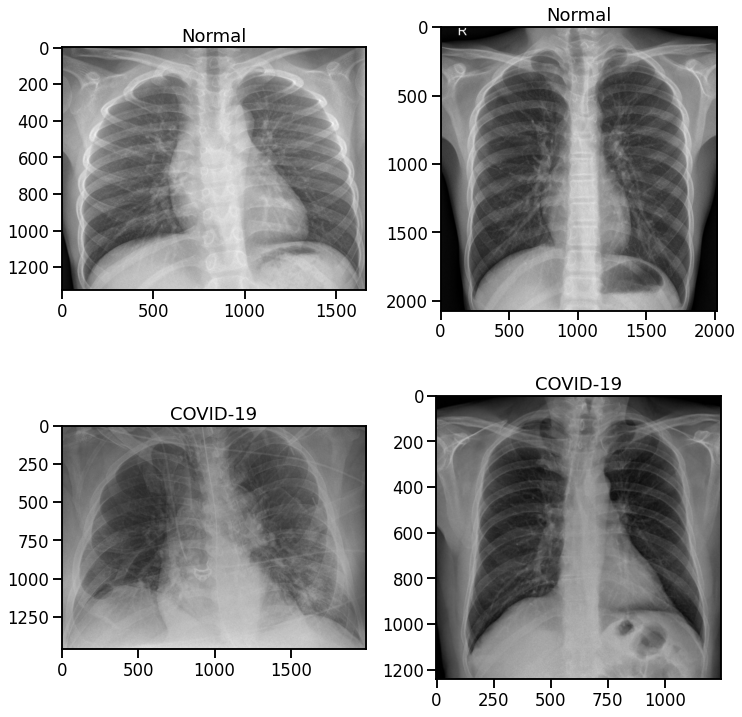

In [ ]:
# Plotting Normal VS Covid in Grid

sns.set_context('talk')
plt.figure(figsize=(12,12))
plt.subplots_adjust(hspace=0.3)

plt.subplot(2, 2, 1)
plt.imshow(mpimg.imread(df_train[df_train['Class'] == 'Normal']['Path'].values[0]),cmap="gray")
plt.title('Normal')

plt.subplot(2, 2, 2)
plt.imshow(mpimg.imread(df_train[df_train['Class'] == 'Normal']['Path'].values[6]),cmap="gray")
plt.title('Normal')

plt.subplot(2, 2, 3)
plt.imshow(mpimg.imread(df_train[df_train['Class'] == 'Covid']['Path'].values[28]),cmap="gray")
plt.title('COVID-19')

plt.subplot(2, 2, 4)
plt.imshow(mpimg.imread(df_train[df_train['Class'] == 'Covid']['Path'].values[26]),cmap="gray")
plt.title('COVID-19')

different images have different size
also the shape is automatically recognised by the package
gray image may not be gray-scaled, some have dimension (width, height, 3)


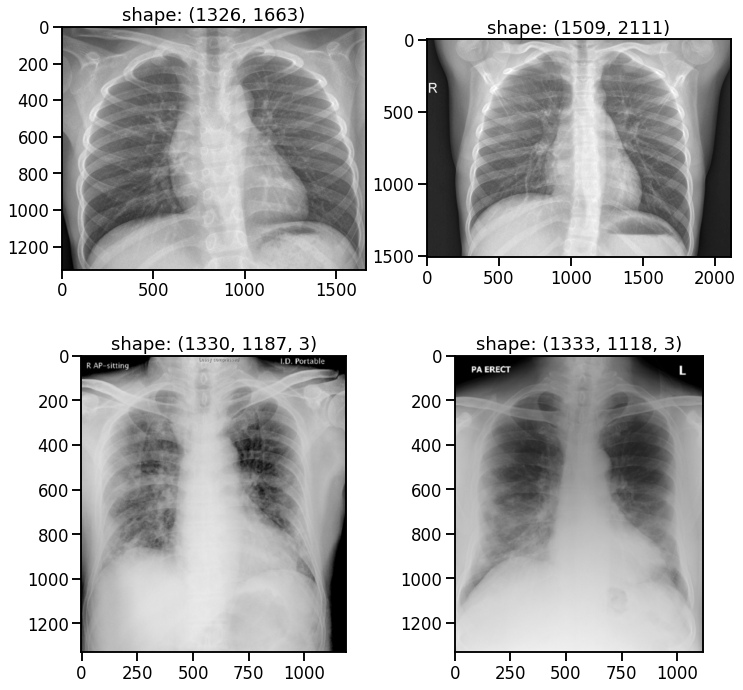

In [ ]:
# problems of using raw data (before processing) for CNN

print('different images have different size')
print('also the shape is automatically recognised by the package')
print('gray image may not be gray-scaled, some have dimension (width, height, 3)')
img0 = mpimg.imread(df_train['Path'][0])
img1 = mpimg.imread(df_train['Path'][3])
img2 = mpimg.imread(df_test['Path'][22])
img3 = mpimg.imread(df_test['Path'][23])

fig, axs = plt.subplots(2, 2, figsize=(12,12))

axs[0,0].imshow(img0,cmap="gray")
axs[0,0].set_title('shape: {}'.format(img0.shape))

axs[0,1].imshow(img1,cmap="gray")
axs[0,1].set_title('shape: {}'.format(img1.shape))

axs[1,0].imshow(img2,cmap="gray")
axs[1,0].set_title('shape: {}'.format(img2.shape))

axs[1,1].imshow(img3,cmap="gray")
axs[1,1].set_title('shape: {}'.format(img3.shape))

plt.show()

In [ ]:
# Pre-processing
# 1. resize all images
# 2. convert all images to have the same dimension (width, height, 3) as 'RGB' images
# note that images in keras are represented in 'RGB' color sequence

def image_preprocessor(path, desired_size=IMG_SIZE):
    im = Image.open(path).convert('RGB')
    im = im.resize((desired_size,desired_size), Image.LANCZOS)
    return im

# training set
x_train = np.empty((len(df_train), IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)

for i, path in enumerate(tqdm(df_train['Path'])):
    x_train[i,:,:,:] = image_preprocessor(path)
    
# testing set
x_test = np.empty((len(df_test), IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)

for i, path in enumerate(tqdm(df_test['Path'])):
    x_test[i,:,:,:] = image_preprocessor(path)
    
x_train = x_train/255.0
x_test = x_test/255.0

100%|██████████| 24/24 [00:01<00:00, 18.87it/s]


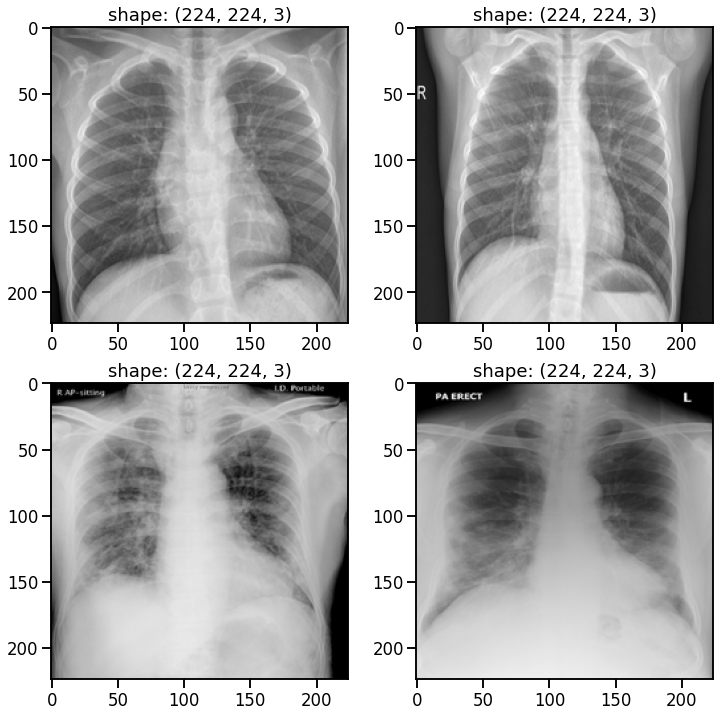

In [ ]:
# some images after processing
# comparing with former examples

fig, axs = plt.subplots(2, 2, figsize=(12,12))

axs[0,0].imshow(x_train[0])
axs[0,0].set_title('shape: {}'.format(x_train[0].shape))

axs[0,1].imshow(x_train[3])
axs[0,1].set_title('shape: {}'.format(x_train[3].shape))

axs[1,0].imshow(x_test[22])
axs[1,0].set_title('shape: {}'.format(x_test[22].shape))

axs[1,1].imshow(x_test[23])
axs[1,1].set_title('shape: {}'.format(x_test[23].shape))

plt.show()

In [ ]:
# Convert the "Class" collumn of the df_train and df_test dataframes into a binary variable
# with 0 indicting Normal and 1 indicating COVID

df_train['Class'] = df_train['Class'].replace(['Covid','Normal'], [1,0])
df_test['Class'] = df_test['Class'].replace(['Covid','Normal'], [1,0])

#defining output layer's output

y_train = to_categorical(df_train['Class'], num_classes=2)
y_test = to_categorical(df_test['Class'], num_classes=2)

In [ ]:
# Data Augmentation

datagen = image.ImageDataGenerator(
    #rescale=1./255,
    vertical_flip = False,
    shear_range = 0,
    zoom_range = 0,
        
    horizontal_flip = True,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='nearest',
    
    validation_split=validation_split)    
    
datagen.fit(x_train, augment=True)
generator_train = datagen.flow(x_train, y_train, subset='training', shuffle=True, batch_size=batch_size)
generator_valid = datagen.flow(x_train, y_train, subset='validation', shuffle=True, batch_size=batch_size)

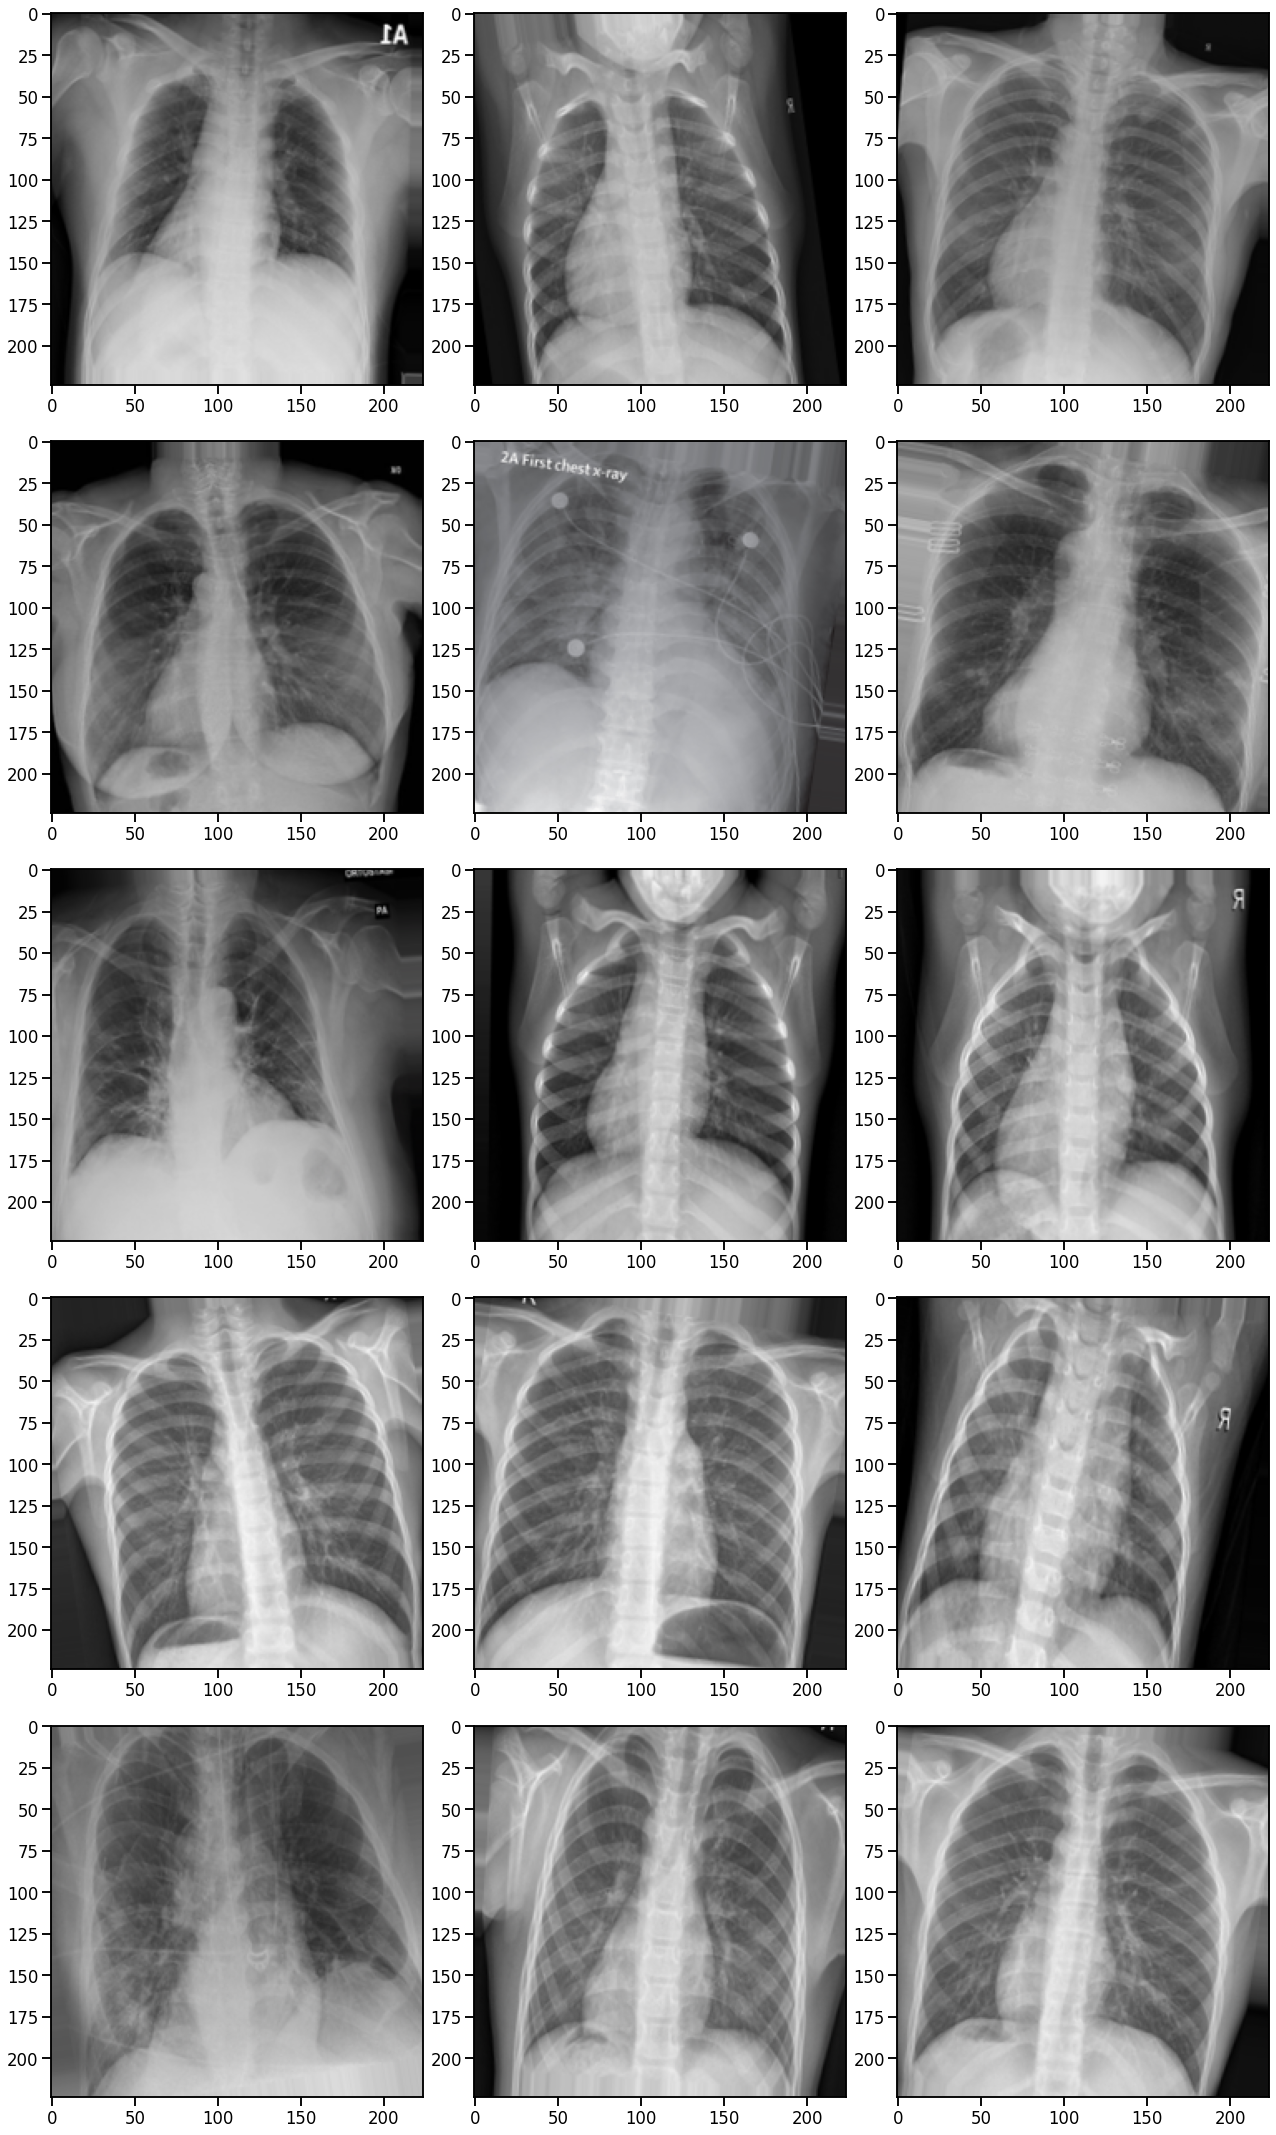

In [ ]:
# visualize the data

plt.figure(figsize=(18, 30))

for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in generator_train:
        image = X_batch[0]
        plt.imshow(image)
        break

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Category Count')

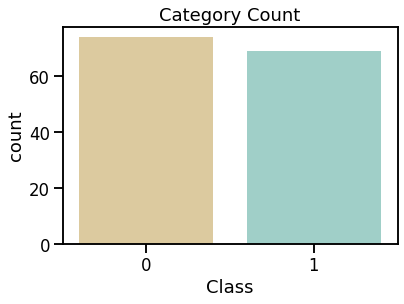

In [ ]:
# additional remark: Category count Plot
sns.countplot(df_train['Class'], palette='BrBG')
plt.title('Category Count')

# Building the CNN (fit on original data)

In [ ]:
from tensorflow.keras.layers import Activation, Dropout, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
model = Sequential()

#Normalization & Input
model.add(BatchNormalization(input_shape=(IMG_SIZE, IMG_SIZE, 3)))

#CNN
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))

#Max Pooling
model.add(MaxPool2D(pool_size=(2,2)))

#Dropout
model.add(Dropout(0.25))

#Flattening I/P
model.add(Flatten())

#Dense layer
model.add(Dense(128, activation='relu'))

#Dropout
model.add(Dropout(0.1))

#Output Layer with sigmoid
model.add(Dense(2, activation='sigmoid'))

#Adam as optimizer, Accuracy as evaluation metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# overview of deep neural network
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 401408)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               51380352  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [ ]:
# Saving best model while monitoring accuracy
model_chkpt = ModelCheckpoint('/content/drive/My Drive/STAT4609/STAT4609_Group_Project/',
                              save_best_only=True, monitor='accuracy')

# early stopping for preventing overfitting
early_stopping = EarlyStopping(monitor='loss', restore_best_weights=False, patience=5)

In [ ]:
# Model fitting and tracking historical accuracy / error score
history = model.fit(x_train, y_train, 
          validation_split=validation_split, 
          epochs=epochs, batch_size=batch_size, shuffle=True, 
          callbacks=[model_chkpt, early_stopping]
         )

Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 19.7325 - accuracy: 0.6400WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/STAT4609/STAT4609_Group_Project/assets
4/4 [==============================] - 5s 1s/step - loss: 19.7325 - accuracy: 0.6400 - val_loss: 0.2409 - val_accuracy: 1.0000
Epoch 2/20
4/4 [==============================] - 3s 808ms/step - loss: 6.1059 - accuracy: 0.8400 - val_loss: 1.2296 - val_accuracy: 1.0000
Epoch 3/20
4/4 [==============================] - 12s 3s/step - loss: 1.5779 - accuracy: 0.9600 - val_loss: 4.3185 - val_accuracy: 0.2791
Epoch 4/20
4/4 [==============================] 

Text(0, 0.5, 'Error')

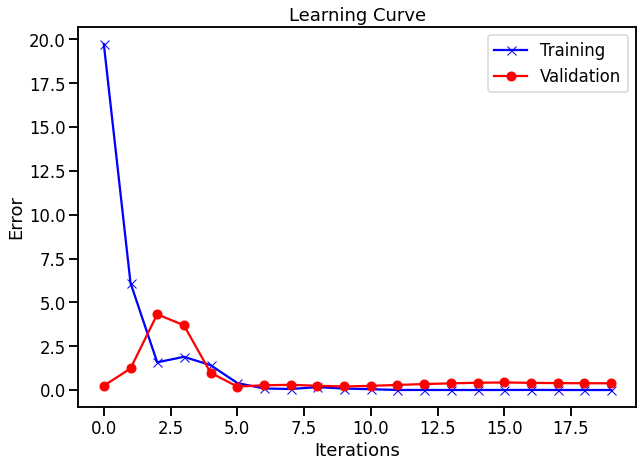

In [ ]:
# plotting Learning curve over No. of Iterations
sns.set_context('talk')
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'], 'b', label='Training', marker='x')
plt.plot(history.history['val_loss'], 'r', label='Validation', marker='o')
plt.legend()
plt.title('Learning Curve')
plt.xlabel('Iterations')
plt.ylabel('Error')

In [ ]:
# prediction on test set
pred = model.predict(x_test, batch_size=batch_size)
# print(pred)

# converting Probabilities to labels
label = np.argmax(pred, axis=1)
label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1])

In [ ]:
# Accuracy Score
print ('Accuracy Score : ', accuracy_score(label, df_test['Class'].values), '\n')

# precision, recall report
print ('Classification Report :\n\n' ,classification_report(label, df_test['Class'].values))

Accuracy Score :  1.0 

Classification Report :

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00         4

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



Text(0.5, 1.0, 'Confusion Matrix')

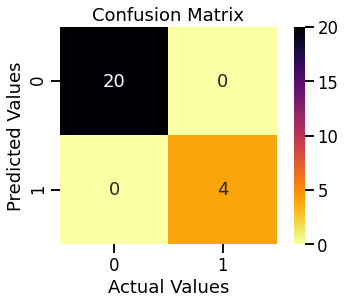

In [ ]:
# plotting confusion matrix
sns.heatmap(confusion_matrix(label, df_test['Class'].values), annot=True, cmap='inferno_r', square=True)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix')

# Building the CNN (fit on augmented data)

In [ ]:
model = Sequential()

#Normalization & Input
model.add(BatchNormalization(input_shape=(IMG_SIZE, IMG_SIZE, 3)))

#CNN
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))

#Max Pooling
model.add(MaxPool2D(pool_size=(2,2)))

#Dropout
model.add(Dropout(0.25))

#Flattening I/P
model.add(Flatten())

#Dense layer
model.add(Dense(128, activation='relu'))

#Dropout
model.add(Dropout(0.1))

#Output Layer with sigmoid
model.add(Dense(2, activation='sigmoid'))

#Adam as optimizer, Accuracy as evaluation metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Saving best model while monitoring accuracy
model_chkpt = ModelCheckpoint('/content/drive/My Drive/STAT4609/STAT4609_Group_Project/',
                              save_best_only=True, monitor='accuracy')

# early stopping for preventing overfitting
early_stopping = EarlyStopping(monitor='loss', restore_best_weights=False, patience=5)

In [ ]:
# Model fitting and tracking historical accuracy / error score
history = model.fit_generator(generator_train,
                              steps_per_epoch=len(x_train)*2/batch_size,
                              validation_data=generator_valid,
                              validation_steps=generator_valid.n//generator_valid.batch_size,
                              epochs=epochs,
                              callbacks=[model_chkpt, early_stopping])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
9/8 [==============================] - 7s 754ms/step - loss: 11.8852 - accuracy: 0.8406 - val_loss: 3.7364 - val_accuracy: 0.7500
Epoch 2/20
9/8 [==============================] - 16s 2s/step - loss: 2.8858 - accuracy: 0.9274 - val_loss: 2.0895 - val_accuracy: 0.7812
Epoch 3/20
9/8 [==============================] - 19s 2s/step - loss: 1.3323 - accuracy: 0.9402 - val_loss: 1.7288 - val_accuracy: 0.5938
Epoch 4/20
9/8 [==============================] - 10s 1s/step - loss: 0.3812 - accuracy: 0.9615 - val_loss: 6.0737 - val_accuracy: 0.1250
Epoch 5/20
9/8 [==============================] - 3s 317ms/step - loss: 0.5588 - accuracy: 0.9565 - val_loss: 12.0337 - val_accuracy: 0.0312
Epoch 6/20
9/8 [==============================] - 3s 307ms/step - loss: 0.3540 - accuracy: 0.9402 - val_loss: 1.6580 - val_accuracy: 0.6562
Epoch 7/20
9/8 [==============================] - 3s 318ms/step - loss: 0.4091 - accurac

Text(0, 0.5, 'Error')

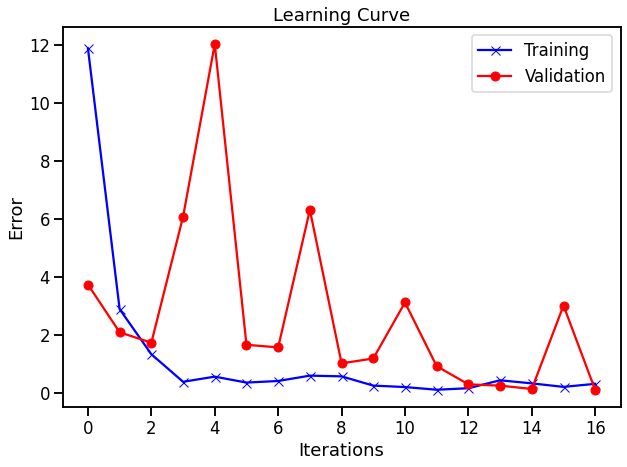

In [ ]:
# plotting Learning curve over No. of Iterations
sns.set_context('talk')
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'], 'b', label='Training', marker='x')
plt.plot(history.history['val_loss'], 'r', label='Validation', marker='o')
plt.legend()
plt.title('Learning Curve')
plt.xlabel('Iterations')
plt.ylabel('Error')

In [ ]:
# prediction on test set
pred = model.predict(x_test, batch_size=32)
# print(pred)

# converting Probabilities to labels
label = np.argmax(pred, axis=1)
label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1])

In [ ]:
# Accuracy Score
print ('Accuracy Score : ', accuracy_score(label, df_test['Class'].values), '\n')

# precision, recall report
print ('Classification Report :\n\n' ,classification_report(label, df_test['Class'].values))

Accuracy Score :  0.9583333333333334 

Classification Report :

               precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.75      1.00      0.86         3

    accuracy                           0.96        24
   macro avg       0.88      0.98      0.92        24
weighted avg       0.97      0.96      0.96        24



Text(0.5, 1.0, 'Confusion Matrix')

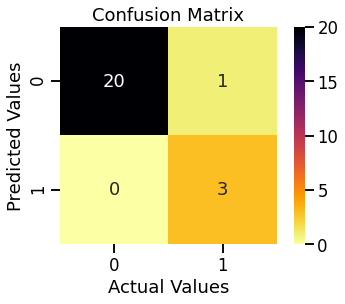

In [ ]:
# plotting confusion matrix
sns.heatmap(confusion_matrix(label, df_test['Class'].values), annot=True, cmap='inferno_r', square=True)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix')

In [ ]:
import numpy as np

from keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.activations import relu

%matplotlib inline
import matplotlib.pyplot as plt
def iter_occlusion(image, size=8):

    occlusion = np.full((size * 5, size * 5, 1), [0.5], np.float32)
    occlusion_center = np.full((size, size, 1), [0.5], np.float32)
    occlusion_padding = size * 2

    # print('padding...')
    image_padded = np.pad(image, ( \
                        (occlusion_padding, occlusion_padding), (occlusion_padding, occlusion_padding), (0, 0) \
                        ), 'constant', constant_values = 0.0)

    for y in range(occlusion_padding, image.shape[0] + occlusion_padding, size):

        for x in range(occlusion_padding, image.shape[1] + occlusion_padding, size):
            tmp = image_padded.copy()

            tmp[y - occlusion_padding:y + occlusion_center.shape[0] + occlusion_padding, \
                x - occlusion_padding:x + occlusion_center.shape[1] + occlusion_padding] \
                = occlusion

            tmp[y:y + occlusion_center.shape[0], x:x + occlusion_center.shape[1]] = occlusion_center

            yield x - occlusion_padding, y - occlusion_padding, \
                  tmp[occlusion_padding:tmp.shape[0] - occlusion_padding, occlusion_padding:tmp.shape[1] - occlusion_padding]

Using TensorFlow backend.


Text(0.5, 1.0, 'Image of infected individual`s lungs \n')

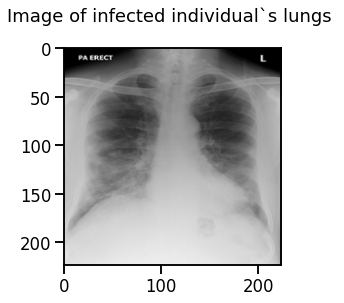

In [ ]:

from tensorflow.keras.preprocessing.image import load_img
# load an image from file
#load_img(("/content/drive/My Drive/STAT4609 Project/xray_dataset_covid19/test/PNEUMONIA/ryct.2020200034.fig5-day7.jpeg", target_size=(224, 224))
#mpimg.imread(df_test['Path'][22])

image = x_test[23]
plt.imshow(image)
plt.title('Image of infected individual`s lungs \n')


(224, 224, 3)
1


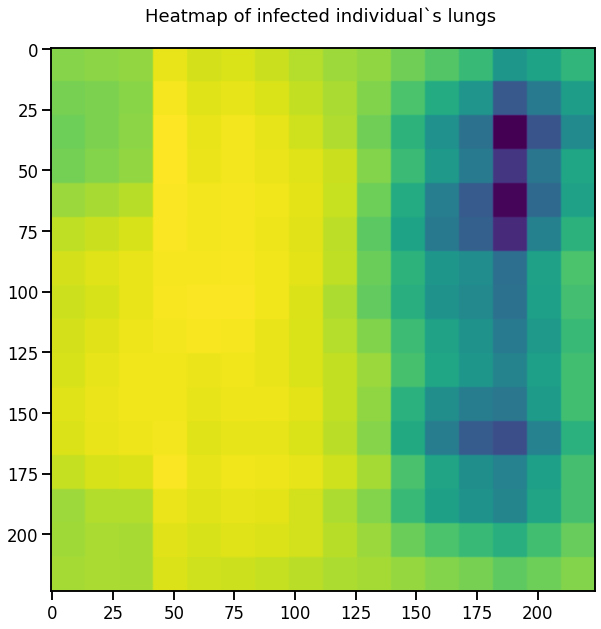

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
#image = preprocess_input(image)
# predict the probability across all output classes
yhat = model.predict(image)
temp = image[0]
print(temp.shape)
heatmap = np.zeros((224,224))
correct_class = np.argmax(yhat)
print(correct_class)
for n,(x,y,image) in enumerate(iter_occlusion(temp,14)):
    heatmap[x:x+14,y:y+14] = model.predict(image.reshape((1, image.shape[0], image.shape[1], image.shape[2])))[0][correct_class]
    #print(x,y,n,' - ',image.shape)
heatmap1 = heatmap/np.max(heatmap)
plt.figure(figsize=(20,10))
plt.title('Heatmap of infected individual`s lungs \n')
plt.imshow(heatmap1)

In [ ]:
print(heatmap1)

[[0.99997401 0.99997401 0.99997401 ... 0.99995077 0.99995077 0.99995077]
 [0.99997401 0.99997401 0.99997401 ... 0.99995077 0.99995077 0.99995077]
 [0.99997401 0.99997401 0.99997401 ... 0.99995077 0.99995077 0.99995077]
 ...
 [0.99998057 0.99998057 0.99998057 ... 0.9999733  0.9999733  0.9999733 ]
 [0.99998057 0.99998057 0.99998057 ... 0.9999733  0.9999733  0.9999733 ]
 [0.99998057 0.99998057 0.99998057 ... 0.9999733  0.9999733  0.9999733 ]]


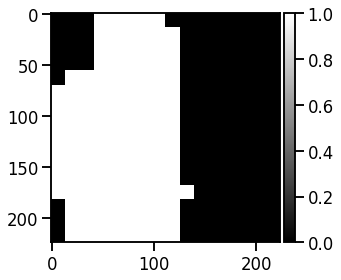

In [ ]:


import skimage.io as io
#creating mask from the standardised heatmap probabilities
mask = heatmap1 > np.quantile(heatmap1,0.5)
mask1 = mask *256
mask = mask.astype(int)
#io.imshow(mask1,cmap='gray')
io.imshow(mask,cmap='gray')

In [ ]:
print(np.quantile(heatmap1,0.85))
print(np.quantile(heatmap1,0.15))

0.9997587749990046
0.9961280615666762


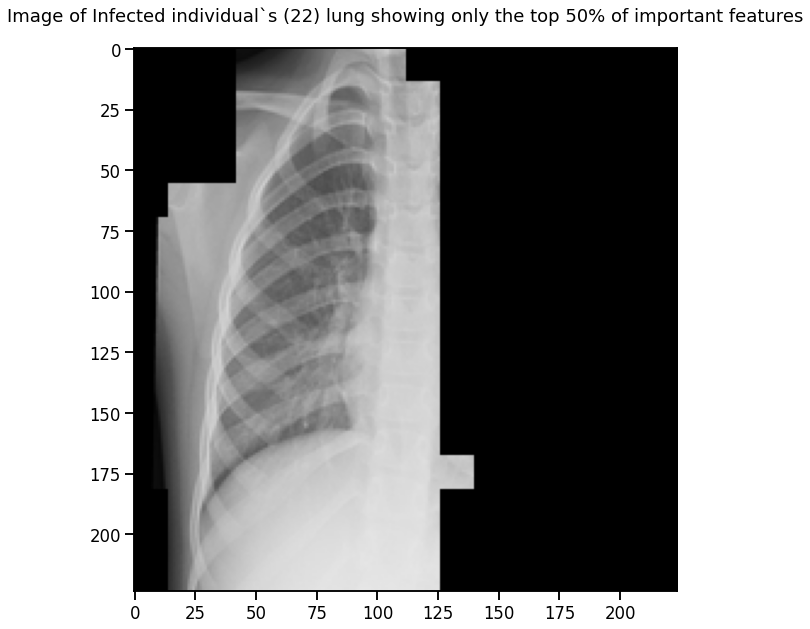

In [ ]:
import cv2
#read the image
image = x_test[10]
#image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
#resize image to appropriate dimensions
#image = cv2.resize(image,(224,224))
mask = mask.astype('uint8')
#apply the mask to the image
final = cv2.bitwise_and(image,image,mask = mask)
final = cv2.cvtColor(final,cv2.COLOR_BGR2RGB)
#plot the final image
plt.figure(figsize=(20,10))
plt.title("Image of Infected individual`s (22) lung showing only the top 50% of important features\n")
plt.imshow(final)

(224, 224, 3)
0


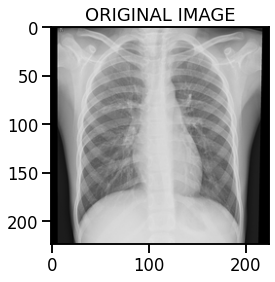

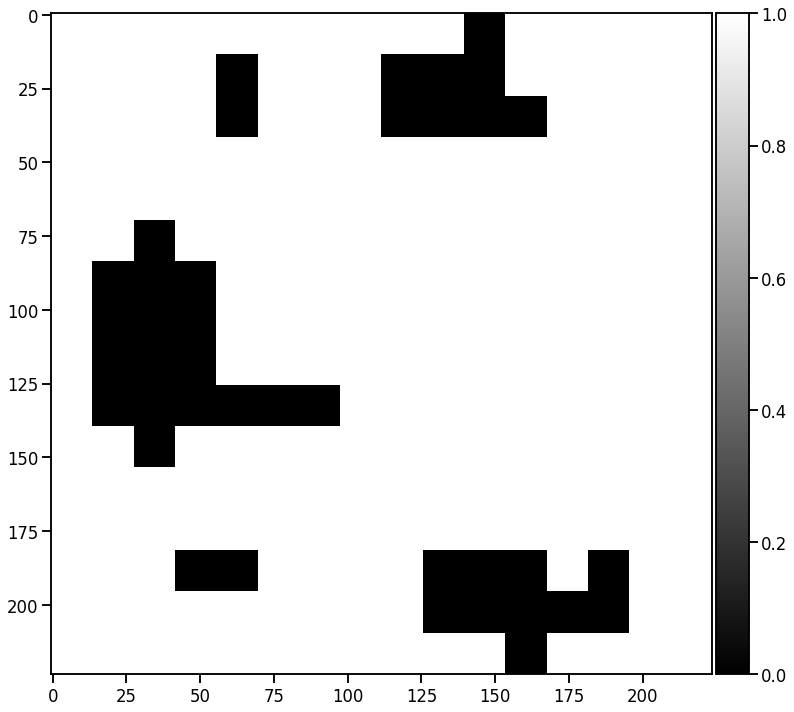

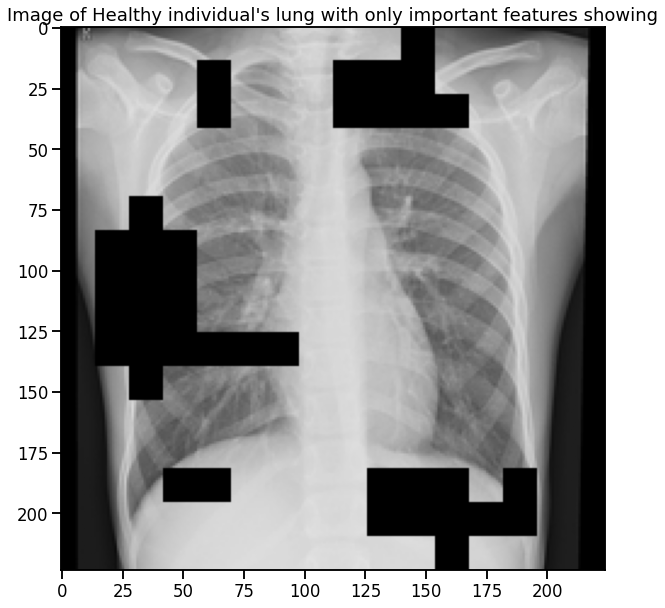

In [ ]:
image = x_test[19]
plt.imshow(image)
plt.title('ORIGINAL IMAGE')
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
#image = preprocess_input(image)
# predict the probability across all output classes
yhat = model.predict(image)
temp = image[0]
print(temp.shape)
heatmap = np.zeros((224,224))
correct_class = np.argmax(yhat)
print(correct_class)
for n,(x,y,image) in enumerate(iter_occlusion(temp,14)):
    heatmap[x:x+14,y:y+14] = model.predict(image.reshape((1, image.shape[0], image.shape[1], image.shape[2])))[0][correct_class]
    #print(x,y,n,' - ',image.shape)
heatmap1 = heatmap/np.max(heatmap)
plt.figure(figsize=(20,10))
plt.imshow(heatmap)

mask = heatmap1 > np.quantile(heatmap1,0.15)
mask1 = mask *256
mask = mask.astype(int)
#io.imshow(mask1,cmap='gray')
io.imshow(mask,cmap='gray')
image = x_test[19]
#image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
#resize image to appropriate dimensions
#image = cv2.resize(image,(224,224))
mask = mask.astype('uint8')
#apply the mask to the image
final = cv2.bitwise_and(image,image,mask = mask)
final = cv2.cvtColor(final,cv2.COLOR_BGR2RGB)
#plot the final image
plt.figure(figsize=(20,10))
plt.title("Image of Healthy individual's lung with only important features showing")
plt.imshow(final)
#plt.imshow(heatmap)